# ML HW4 sample code
TODO:
 - Handler missing values
  - ref: https://www.geeksforgeeks.org/ml-handling-missing-values/
 - Surrogate loss
  - ref: https://ar5iv.labs.arxiv.org/html/2203.15046
 - Calculate AUC
 - Design the model and tune hyperparameters

Report:
 - Ablation study
 - Saliency map

In [ ]:
!gdown 1L6P8E3nPDGivYcLeTjjCkHrEtBu-aDly
!unzip -q 'HW4.zip'

Downloading...
From: https://drive.google.com/uc?id=1L6P8E3nPDGivYcLeTjjCkHrEtBu-aDly
To: /content/HW4.zip
100% 5.73M/5.73M [00:00<00:00, 40.1MB/s]
replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import numpy as np
import csv
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from argparse import Namespace

In [ ]:
config = Namespace(
    num_epochs=50,
    lr=1e-7,
    weight_decay=0, # default=0, L2 Regularization
    batch_size=128,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    ckpt_path='model.ckpt'
)

## Data Processing

In [ ]:
data_dir = './data'

def handle_missing_values(df):
    # TODO: handle missing values
    # Determine the data type for each column and pad missing values accordingly
    for column in df.columns:
        if pd.api.types.is_integer_dtype(df[column]): # categorical
            df[column] = df[column].fillna(-1)#.astype('Int64')  # pad -1 for missing values
            # add 1 to all values to ensure all categorical values >= 0
            df[column] = df[column] + 1
        elif pd.api.types.is_float_dtype(df[column]): # float
            df[column] = df[column].fillna(-100) # pad -100 for missing values
            # # Calculate the mean of the column, ignoring NaN values
            # column_mean = df[column].mean(skipna=True)
            # # Pad missing values with the calculated mean
            # df[column] = df[column].fillna(column_mean)

# load data using pandas
def load_csv(file_name, labelled=True, categories=None):
    # no header in the csv file
    df = pd.read_csv(file_name, header=None)

    # if labelled, remove the rows where the label (column 0) is missing
    if labelled:
        lab = df[0].values
        df.drop(columns=0, inplace=True)

    # convert string features into integers
    if categories is not None:
        i = 0
        for col in df.columns:
            if df[col].dtype == 'object' or pd.api.types.is_integer_dtype(df[col]):
                df[col] = pd.Categorical(df[col], categories=categories[i])
                df[col] = df[col].cat.codes
                i += 1
    else:
        categories = []
        for col in df.columns:
            if df[col].dtype == 'object' or pd.api.types.is_integer_dtype(df[col]):
                categories.append(df[col].dropna().unique())
                df[col] = pd.Categorical(df[col], categories=categories[-1])
                df[col] = df[col].cat.codes

    # handle missing values
    handle_missing_values(df)

    # convert from pd to 2 numpy array for categorical and float features
    cat = df[[x for x in df.columns if pd.api.types.is_integer_dtype(df[x])]].values
    flt = df[[x for x in df.columns if pd.api.types.is_float_dtype(df[x])]].values
    # list of numbers of unique values for each categorical feature
    num_cat = (cat.max(axis=0) + 1).tolist()
    if labelled:
        return lab, cat, flt, num_cat, categories
    else:
        return cat, flt, num_cat

In [ ]:
# dataset
class PPD(torch.utils.data.Dataset):
    def __init__(self, cat_data, num_data, label=None):
        self.cat_data = cat_data
        self.num_data = num_data
        self.label = label

    def t(self, x):
        return torch.from_numpy(x)

    def __getitem__(self, idx):
        if self.label is not None:
            return self.t(self.cat_data[idx]).long(), self.t(self.num_data[idx]).float(), torch.tensor(self.label[idx]).long()
        else:
            return self.t(self.cat_data[idx]).long(), self.t(self.num_data[idx]).float()

    def __len__(self):
        return len(self.cat_data)

In [ ]:
train_label, train_cat_data, train_num_data, num_cat, categories = load_csv(data_dir + '/train.csv', labelled=True)
train_dataset, valid_dataset = torch.utils.data.random_split(PPD(train_cat_data, train_num_data, label=train_label), [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)


# from imblearn.combine import SMOTEENN
# # Combine SMOTE and EditedNearestNeighbours on Training_data
# smote_enn = SMOTEENN(random_state=42)

# # Resample the training data
# train_cat_data_resampled, train_label_resampled = smote_enn.fit_resample(train_cat_data, train_label)

# # Create a new training dataset with the resampled data
# train_dataset_resampled = PPD(train_cat_data_resampled, train_num_data[:len(train_cat_data_resampled)], label=train_label_resampled)

# # Create a new data loader for the resampled training data
# train_loader = torch.utils.data.DataLoader(train_dataset_resampled, batch_size=config.batch_size, shuffle=True)

## Model

In [ ]:
class simple_nn(nn.Module):
    def __init__(self, num_cat, emb_size=64):
        super().__init__()
        self.num_cat = num_cat
        self.emb = nn.ModuleList([nn.Embedding(n, emb_size) for n in num_cat])
        number_of_emb = emb_size*len(num_cat) + 103-len(num_cat)

        self.fc = nn.Sequential(
            nn.Linear(number_of_emb, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.BatchNorm1d(1024),
            # nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x_cat, x_num):
        x_cat_emb = []
        for i in range(x_cat.size(1)):
            # print(x_cat[:, i])
            x_cat_emb.append(self.emb[i](x_cat[:, i]))
        x_cat_emb = torch.cat(x_cat_emb, 1)
        x = torch.cat([x_cat_emb, x_num], 1)
        x = self.fc(x)
        return x.squeeze()

## functions

In [ ]:
# TODO: Loss function
# implement your loss function (surrrogate loss)
def loss_function(y_pred, y_true):
    # return nn.BCELoss()(y_pred, y_true)

    positive_mask = y_true == 1
    negative_mask = y_true == 0

    positive_predictions = y_pred[positive_mask]
    negative_predictions = y_pred[negative_mask]

    # Broadcasting to avoid nested loops
    diff = positive_predictions.unsqueeze(1) - negative_predictions  # Shape: (num_pos, num_neg)
    loss = torch.sum((torch.clamp(1 - diff, min=0)**2))  # maximum: squared hinge loss
    # loss = torch.logsumexp(-diff, dim=1).sum() # exponential
    # Normalize by number of pairs
    # num_pairs = positive_predictions.size(0) * negative_predictions.size(0)
    # loss = loss / num_pairs
    return loss

In [ ]:
from sklearn.metrics import roc_auc_score

def auc(y_pred, y_true):
    y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()
    return roc_auc_score(y_true, y_pred)

In [ ]:
def train(model, train_loader, valid_loader, config):
    model.to(config.device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.num_epochs)

    best_auc = 0
    for epoch in range(config.num_epochs):
        model.train()
        all_y_true, all_y_pred, all_loss = [], [], []
        for x_cat, x_num, y in tqdm(train_loader):
            x_cat, x_num, y = x_cat.to(config.device), x_num.to(config.device), y.to(config.device).float()
            y_pred = model(x_cat, x_num)

            loss = loss_function(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            all_y_true.append(y)
            all_y_pred.append(y_pred)
            all_loss.append(loss)
        all_y_true = torch.cat(all_y_true)
        all_y_pred = torch.cat(all_y_pred)
        auc_score = auc(all_y_pred.detach(), all_y_true)
        loss = torch.mean(torch.stack(all_loss))
        print(f'Epoch {epoch+1}/{config.num_epochs}, train loss: {loss.item()}, train AUC: {auc_score}')


        model.eval()
        with torch.no_grad():
            y_true = []
            y_pred = []
            for x_cat, x_num, y in valid_loader:
                x_cat, x_num, y = x_cat.to(config.device), x_num.to(config.device), y.to(config.device).float()
                y_true.append(y)
                y_pred.append(model(x_cat, x_num))
            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)
            auc_score = auc(y_pred, y_true)
            loss = loss_function(y_pred, y_true)
            print(f'Epoch {epoch+1}/{config.num_epochs}, valid loss: {loss.item()}, valid AUC: {auc_score}')


            if auc_score > best_auc:
                best_auc = auc_score
                torch.save(model.state_dict(), config.ckpt_path)
                print(f'==== best valid AUC: {auc_score} ====')
        scheduler.step()
    model.load_state_dict(torch.load(config.ckpt_path))

# xgBoosting

In [ ]:
import xgboost as xgb

# 1. Prepare training data for XGBoost
X_train = np.concatenate((train_cat_data, train_num_data), axis=1)
y_train = train_label

# 2. Prepare validation data for XGBoost
X_val = []
y_val = []
for x_cat, x_num, y in valid_dataset:  # Iterate through valid_dataset
    X_val.append(np.concatenate((x_cat.cpu().numpy(), x_num.cpu().numpy())))  # Combine features
    y_val.append(y.item())  # Extract label

X_val = np.array(X_val)
y_val = np.array(y_val)

# 3. Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set Hyperparameters
params = {
    'objective': 'binary:logistic',
    # 'objective': 'binary:hinge',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

# Train the Model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds, evals=[(dval, 'eval')], early_stopping_rounds=10)

# Prediction and Evaluation
y_pred_prob = xgb_model.predict(dval)
auc_score = roc_auc_score(y_val, y_pred_prob)
print(f"Validation AUC: {auc_score}")

[0]	eval-auc:0.62027
[1]	eval-auc:0.62527
[2]	eval-auc:0.63195
[3]	eval-auc:0.64147
[4]	eval-auc:0.64486
[5]	eval-auc:0.64924
[6]	eval-auc:0.65258
[7]	eval-auc:0.65710
[8]	eval-auc:0.65982
[9]	eval-auc:0.66659
[10]	eval-auc:0.66710
[11]	eval-auc:0.67248
[12]	eval-auc:0.67411
[13]	eval-auc:0.67690
[14]	eval-auc:0.67926
[15]	eval-auc:0.68057
[16]	eval-auc:0.68050
[17]	eval-auc:0.68102
[18]	eval-auc:0.68435
[19]	eval-auc:0.68659
[20]	eval-auc:0.68880
[21]	eval-auc:0.69136
[22]	eval-auc:0.69296
[23]	eval-auc:0.69407
[24]	eval-auc:0.69627
[25]	eval-auc:0.69895
[26]	eval-auc:0.69962
[27]	eval-auc:0.70305
[28]	eval-auc:0.70530
[29]	eval-auc:0.70640
[30]	eval-auc:0.70825
[31]	eval-auc:0.70835
[32]	eval-auc:0.71238
[33]	eval-auc:0.71387
[34]	eval-auc:0.71596
[35]	eval-auc:0.71734
[36]	eval-auc:0.71805
[37]	eval-auc:0.71975
[38]	eval-auc:0.72055
[39]	eval-auc:0.72072
[40]	eval-auc:0.72230
[41]	eval-auc:0.72299
[42]	eval-auc:0.72475
[43]	eval-auc:0.72620
[44]	eval-auc:0.72662
[45]	eval-auc:0.7273

## Train

In [ ]:
model = simple_nn(num_cat)
train(model, train_loader, valid_loader, config)

100%|██████████| 107/107 [00:01<00:00, 71.83it/s]


Epoch 1/50, train loss: 2333.829345703125, train AUC: 0.5070036672412292
Epoch 1/50, valid loss: 1575088.875, valid AUC: 0.5322164598550055
==== best valid AUC: 0.5322164598550055 ====


100%|██████████| 107/107 [00:01<00:00, 75.19it/s]


Epoch 2/50, train loss: 2326.078857421875, train AUC: 0.5142802843316696
Epoch 2/50, valid loss: 1573527.25, valid AUC: 0.53086578006336


100%|██████████| 107/107 [00:01<00:00, 75.52it/s]


Epoch 3/50, train loss: 2315.127685546875, train AUC: 0.5188725055395642
Epoch 3/50, valid loss: 1571057.0, valid AUC: 0.537903333255454
==== best valid AUC: 0.537903333255454 ====


100%|██████████| 107/107 [00:01<00:00, 74.14it/s]


Epoch 4/50, train loss: 2305.10888671875, train AUC: 0.5302083951392187
Epoch 4/50, valid loss: 1568469.25, valid AUC: 0.5412323579686635
==== best valid AUC: 0.5412323579686635 ====


100%|██████████| 107/107 [00:01<00:00, 76.26it/s]


Epoch 5/50, train loss: 2299.633056640625, train AUC: 0.5395806270512652
Epoch 5/50, valid loss: 1565225.5, valid AUC: 0.5457513574679206
==== best valid AUC: 0.5457513574679206 ====


100%|██████████| 107/107 [00:01<00:00, 64.33it/s]


Epoch 6/50, train loss: 2288.944091796875, train AUC: 0.5458379176358582
Epoch 6/50, valid loss: 1564154.375, valid AUC: 0.5494270503464472
==== best valid AUC: 0.5494270503464472 ====


100%|██████████| 107/107 [00:01<00:00, 53.74it/s]


Epoch 7/50, train loss: 2279.695556640625, train AUC: 0.5553833879935799
Epoch 7/50, valid loss: 1560943.375, valid AUC: 0.5544736295399164
==== best valid AUC: 0.5544736295399164 ====


100%|██████████| 107/107 [00:01<00:00, 75.75it/s]


Epoch 8/50, train loss: 2276.544921875, train AUC: 0.5620545646702149
Epoch 8/50, valid loss: 1558617.0, valid AUC: 0.5588095074217929
==== best valid AUC: 0.5588095074217929 ====


100%|██████████| 107/107 [00:01<00:00, 75.44it/s]


Epoch 9/50, train loss: 2270.353515625, train AUC: 0.565650782466274
Epoch 9/50, valid loss: 1559071.75, valid AUC: 0.5587435204941504


100%|██████████| 107/107 [00:01<00:00, 75.56it/s]


Epoch 10/50, train loss: 2258.576416015625, train AUC: 0.5743450822493898
Epoch 10/50, valid loss: 1558085.5, valid AUC: 0.5592407904034169
==== best valid AUC: 0.5592407904034169 ====


100%|██████████| 107/107 [00:01<00:00, 76.14it/s]


Epoch 11/50, train loss: 2258.139892578125, train AUC: 0.5774319379785657
Epoch 11/50, valid loss: 1550297.125, valid AUC: 0.5708030261794453
==== best valid AUC: 0.5708030261794453 ====


100%|██████████| 107/107 [00:02<00:00, 40.73it/s]


Epoch 12/50, train loss: 2240.1376953125, train AUC: 0.5936278031761273
Epoch 12/50, valid loss: 1551685.125, valid AUC: 0.5657333989203402


100%|██████████| 107/107 [00:01<00:00, 56.13it/s]


Epoch 13/50, train loss: 2241.19970703125, train AUC: 0.5946947359005026
Epoch 13/50, valid loss: 1544381.25, valid AUC: 0.575770673641285
==== best valid AUC: 0.575770673641285 ====


100%|██████████| 107/107 [00:01<00:00, 75.31it/s]


Epoch 14/50, train loss: 2238.82958984375, train AUC: 0.5962551807763793
Epoch 14/50, valid loss: 1550016.125, valid AUC: 0.5711781097681491


100%|██████████| 107/107 [00:01<00:00, 75.65it/s]


Epoch 15/50, train loss: 2230.68505859375, train AUC: 0.6060842554394953
Epoch 15/50, valid loss: 1544932.875, valid AUC: 0.5783732106965757
==== best valid AUC: 0.5783732106965757 ====


100%|██████████| 107/107 [00:01<00:00, 76.41it/s]


Epoch 16/50, train loss: 2222.962158203125, train AUC: 0.6058819525409109
Epoch 16/50, valid loss: 1547169.875, valid AUC: 0.5757937217069209


100%|██████████| 107/107 [00:01<00:00, 75.41it/s]


Epoch 17/50, train loss: 2216.3193359375, train AUC: 0.6120442377538508
Epoch 17/50, valid loss: 1546116.375, valid AUC: 0.5758647602653875


100%|██████████| 107/107 [00:01<00:00, 76.16it/s]


Epoch 18/50, train loss: 2213.282958984375, train AUC: 0.6145417288741334
Epoch 18/50, valid loss: 1538576.0, valid AUC: 0.5849213871525663
==== best valid AUC: 0.5849213871525663 ====


100%|██████████| 107/107 [00:01<00:00, 75.42it/s]


Epoch 19/50, train loss: 2197.75390625, train AUC: 0.6228240438020882
Epoch 19/50, valid loss: 1538353.625, valid AUC: 0.5840323001274905


100%|██████████| 107/107 [00:01<00:00, 59.78it/s]


Epoch 20/50, train loss: 2202.534912109375, train AUC: 0.624607592237472
Epoch 20/50, valid loss: 1537977.375, valid AUC: 0.5832783442269648


100%|██████████| 107/107 [00:01<00:00, 65.83it/s]


Epoch 21/50, train loss: 2199.35107421875, train AUC: 0.6259826947536704
Epoch 21/50, valid loss: 1529536.75, valid AUC: 0.5928903347778893
==== best valid AUC: 0.5928903347778893 ====


100%|██████████| 107/107 [00:01<00:00, 76.75it/s]


Epoch 22/50, train loss: 2198.83935546875, train AUC: 0.6280111639123704
Epoch 22/50, valid loss: 1531342.375, valid AUC: 0.5925471396087638


100%|██████████| 107/107 [00:01<00:00, 76.02it/s]


Epoch 23/50, train loss: 2193.280517578125, train AUC: 0.6313393073082492
Epoch 23/50, valid loss: 1532625.625, valid AUC: 0.5919185272980657


100%|██████████| 107/107 [00:01<00:00, 75.18it/s]


Epoch 24/50, train loss: 2183.231201171875, train AUC: 0.6335666533743227
Epoch 24/50, valid loss: 1530942.0, valid AUC: 0.5925439823394987


100%|██████████| 107/107 [00:01<00:00, 76.27it/s]


Epoch 25/50, train loss: 2187.28173828125, train AUC: 0.637132790214586
Epoch 25/50, valid loss: 1528191.25, valid AUC: 0.5914945060357517


100%|██████████| 107/107 [00:01<00:00, 76.20it/s]


Epoch 26/50, train loss: 2183.028564453125, train AUC: 0.637005821474384
Epoch 26/50, valid loss: 1525770.625, valid AUC: 0.5970026779957908
==== best valid AUC: 0.5970026779957908 ====


100%|██████████| 107/107 [00:01<00:00, 65.48it/s]


Epoch 27/50, train loss: 2176.49462890625, train AUC: 0.6399771911811523
Epoch 27/50, valid loss: 1523296.25, valid AUC: 0.6006840539589947
==== best valid AUC: 0.6006840539589947 ====


100%|██████████| 107/107 [00:01<00:00, 59.95it/s]


Epoch 28/50, train loss: 2180.5322265625, train AUC: 0.6376820782559642
Epoch 28/50, valid loss: 1517994.0, valid AUC: 0.6066793925666515
==== best valid AUC: 0.6066793925666515 ====


100%|██████████| 107/107 [00:01<00:00, 76.54it/s]


Epoch 29/50, train loss: 2175.392333984375, train AUC: 0.6394408729636436
Epoch 29/50, valid loss: 1526870.0, valid AUC: 0.593437173814619


100%|██████████| 107/107 [00:01<00:00, 76.22it/s]


Epoch 30/50, train loss: 2172.56103515625, train AUC: 0.6421126002083605
Epoch 30/50, valid loss: 1522141.625, valid AUC: 0.5976401306604312


100%|██████████| 107/107 [00:01<00:00, 75.57it/s]


Epoch 31/50, train loss: 2166.837646484375, train AUC: 0.6468035727892869
Epoch 31/50, valid loss: 1518923.0, valid AUC: 0.6003282297128085


100%|██████████| 107/107 [00:01<00:00, 76.16it/s]


Epoch 32/50, train loss: 2165.082275390625, train AUC: 0.644861826386126
Epoch 32/50, valid loss: 1518846.5, valid AUC: 0.6018443504139496


100%|██████████| 107/107 [00:01<00:00, 77.16it/s]


Epoch 33/50, train loss: 2172.009521484375, train AUC: 0.6460803686336424
Epoch 33/50, valid loss: 1523440.5, valid AUC: 0.5971798008015675


100%|██████████| 107/107 [00:01<00:00, 71.52it/s]


Epoch 34/50, train loss: 2161.976806640625, train AUC: 0.6482904906230245
Epoch 34/50, valid loss: 1515045.75, valid AUC: 0.6042306145245753


100%|██████████| 107/107 [00:01<00:00, 55.96it/s]


Epoch 35/50, train loss: 2160.994140625, train AUC: 0.648629324918597
Epoch 35/50, valid loss: 1522091.0, valid AUC: 0.5972382102829734


100%|██████████| 107/107 [00:01<00:00, 72.93it/s]


Epoch 36/50, train loss: 2161.42724609375, train AUC: 0.6495219462220276
Epoch 36/50, valid loss: 1512049.0, valid AUC: 0.6106761797294473
==== best valid AUC: 0.6106761797294473 ====


100%|██████████| 107/107 [00:01<00:00, 75.22it/s]


Epoch 37/50, train loss: 2160.910400390625, train AUC: 0.6496708074225492
Epoch 37/50, valid loss: 1521069.375, valid AUC: 0.5991770893387226


100%|██████████| 107/107 [00:01<00:00, 76.69it/s]


Epoch 38/50, train loss: 2158.467529296875, train AUC: 0.6499732735037304
Epoch 38/50, valid loss: 1515432.75, valid AUC: 0.6079511406266674


100%|██████████| 107/107 [00:01<00:00, 75.75it/s]


Epoch 39/50, train loss: 2153.523193359375, train AUC: 0.6525679535944596
Epoch 39/50, valid loss: 1513447.75, valid AUC: 0.60553330382339


100%|██████████| 107/107 [00:01<00:00, 77.50it/s]


Epoch 40/50, train loss: 2155.8720703125, train AUC: 0.6486823713099816
Epoch 40/50, valid loss: 1515732.5, valid AUC: 0.606152128599366


100%|██████████| 107/107 [00:01<00:00, 75.97it/s]


Epoch 41/50, train loss: 2154.592041015625, train AUC: 0.6517269292245935
Epoch 41/50, valid loss: 1513651.625, valid AUC: 0.6070778399479176


100%|██████████| 107/107 [00:01<00:00, 63.78it/s]


Epoch 42/50, train loss: 2149.442138671875, train AUC: 0.6504634726087861
Epoch 42/50, valid loss: 1515419.25, valid AUC: 0.6036392579912063


100%|██████████| 107/107 [00:01<00:00, 58.39it/s]


Epoch 43/50, train loss: 2152.516357421875, train AUC: 0.6499994578651271
Epoch 43/50, valid loss: 1513335.5, valid AUC: 0.6056624361363359


100%|██████████| 107/107 [00:01<00:00, 76.94it/s]


Epoch 44/50, train loss: 2149.218017578125, train AUC: 0.6544858121797829
Epoch 44/50, valid loss: 1514453.25, valid AUC: 0.6077737020939641


100%|██████████| 107/107 [00:01<00:00, 76.43it/s]


Epoch 45/50, train loss: 2153.3837890625, train AUC: 0.6506668108343847
Epoch 45/50, valid loss: 1515135.75, valid AUC: 0.6038934181670536


100%|██████████| 107/107 [00:01<00:00, 76.76it/s]


Epoch 46/50, train loss: 2154.034423828125, train AUC: 0.6506468007868184
Epoch 46/50, valid loss: 1515064.75, valid AUC: 0.6065467872575139


100%|██████████| 107/107 [00:01<00:00, 73.95it/s]


Epoch 47/50, train loss: 2148.16650390625, train AUC: 0.653880221172957
Epoch 47/50, valid loss: 1528282.0, valid AUC: 0.5932370029432064


100%|██████████| 107/107 [00:01<00:00, 76.58it/s]


Epoch 48/50, train loss: 2148.962646484375, train AUC: 0.654287669413383
Epoch 48/50, valid loss: 1517716.5, valid AUC: 0.6032698574871799


100%|██████████| 107/107 [00:01<00:00, 75.79it/s]


Epoch 49/50, train loss: 2152.876220703125, train AUC: 0.6536489479421012
Epoch 49/50, valid loss: 1517154.0, valid AUC: 0.6040664365227857


100%|██████████| 107/107 [00:02<00:00, 40.56it/s]
<ipython-input-87-ed766a1f158b>:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config.c

Epoch 50/50, train loss: 2150.990234375, train AUC: 0.6528944769106264
Epoch 50/50, valid loss: 1511503.25, valid AUC: 0.6101928018049477


## Test

Testing on XGboost

In [ ]:
test_cat_data, test_num_data, nc = load_csv(data_dir + '/test.csv', labelled=False, categories=categories)
test_dataset = PPD(test_cat_data, test_num_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
X_test = np.concatenate((test_cat_data, test_num_data), axis=1)
dtest = xgb.DMatrix(X_test)  # Create DMatrix for test data

# 2. Generate predictions
test_predictions = xgb_model.predict(dtest)  # Use the trained model to predict

# 3. Save predictions to predict.csv
predictions_with_ids = []
for i in range(len(test_predictions)):
    predictions_with_ids.append([i, test_predictions[i]])

with open('predict_xgb.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])  # Write header
    writer.writerows(predictions_with_ids)

print("XGboost Predictions saved to predict_xgb.csv")

XGboost Predictions saved to predict_xgb.csv


In [ ]:
test_cat_data, test_num_data, nc = load_csv(data_dir + '/test.csv', labelled=False, categories=categories)
test_dataset = PPD(test_cat_data, test_num_data)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

# Generate predictions
predictions = []
with torch.no_grad():
    model.eval().cuda()
    for x_cat, x_num in test_loader:
        x_cat, x_num = x_cat.to(config.device), x_num.to(config.device)
        predictions.extend(model(x_cat, x_num).cpu().tolist())

# save
with open('predict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for i, p in enumerate(predictions):
        writer.writerow([i, p])

## Feature importance

In [ ]:
categorical_features = ['urbanization', 'Sex_boy', 'unexpectedPre', 'firstborn', 'singleton',
       'edu_M_high', 'martial', 'Somke_perinatal', 'family support_good',
       'income', 'baby_health', 'Alcohol_preg', 'Jobstress_preg',
       'Job_stress_6m', 'AD_B', 'AS_M', 'AR_M', 'AD_M', 'allergy_M', 'PET',
       'incense', 'mold', 'water_wall', 'Vitamin_tri1', 'Vitamin_tri23',
       'Vitamin_p', 'fishliveroil_tri1', 'fishliveroil_tri23', 'fishoil_tri1',
       'fishoil_tri23', 'antibiotic_p', 'Vitamin_post', 'fishliveroil_post',
       'Probiotics_post', 'burn_around_house', 'industry_around_house',
       'odor_around_house', 'paintrenov_p', 'paintrenov_post',
       'pure_day_time_work_preg', 'pure_night_work_preg', 'shift_work_preg',
       'pure_day_time_work_6m', 'pure_night_work_6m', 'shift_work_6m']
continuous_features = ['birth_month', 'Gestation', 'birth_weight', 'Parity', 'multibirth',
       'mother_age', 'Height_M', 'BW_before_P', 'BMI_before_P', 'BW_before_D',
       'BWgain', 'CS', 'tocolysis', 'breastfeed', 'APGAR_1', 'APGAR_5',
       'edu_F_high', 'Somke_perg.', 'sencondsmoke_6m', 'Y0_CO', 'Tri1_CO',
       'Tri2_CO', 'Tri3_CO', '365_CO', 'Y0_NO2', 'Tri1_NO2', 'Tri2_NO2',
       'Tri3_NO2', '365_NO2', 'Y0_PM25', 'Tri1_PM25', 'Tri2_PM25', 'Tri3_PM25',
       '365_PM25', 'Tri1_PM10', 'Tri2_PM10', 'Tri3_PM10', 'Tri1_SO2',
       'Tri2_SO2', 'Tri3_SO2', 'Tri1_O3', 'Tri2_O3', 'Tri3_O3', 'Tri1_NOx',
       'Tri2_NOx', 'Tri3_NOx', 'Tri1_NO', 'Tri2_NO', 'Tri3_NO', 'Tri1_TEMP',
       'Tri2_TEMP', 'Tri3_TEMP', 'Mean NOx', 'Mean NO', 'Mean TEMP', 'Tri1_RH',
       'Tri2_RH', 'Tri3_RH']

### Ablation Study

[ 8  3 13 21 22]
Most Important Categorical Features: ['family support_good', 'firstborn', 'Job_stress_6m', 'mold', 'water_wall']
[30  9 34  1 14]
Most Important Continuous Features: ['Tri1_PM25', 'BW_before_D', 'Tri1_PM10', 'Gestation', 'APGAR_1']


<BarContainer object of 58 artists>

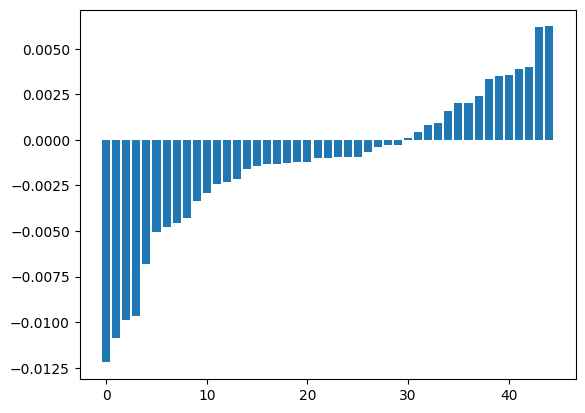

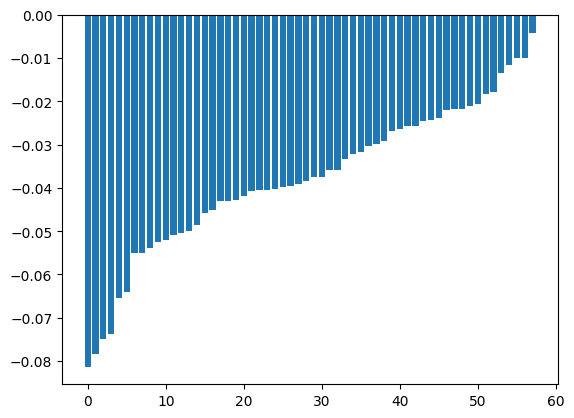

In [ ]:
all_auc = []
model.eval()

with torch.no_grad():
    for i in range(len(num_cat)):
        auc_ = 0
        for x_cat, x_num, y in valid_loader:
            x_cat, x_num = x_cat.to(config.device), x_num.to(config.device)
            x_cat[:, i] = 0
            y_pred = model(x_cat, x_num)
            auc_ += auc(y_pred, y)
        all_auc.append(auc_/len(valid_loader))

    for i in range(len(num_cat), 103):
        auc_ = 0
        for x_cat, x_num, y in valid_loader:
            x_cat, x_num = x_cat.to(config.device), x_num.to(config.device)
            x_num[:, i-len(num_cat)] = -100
            y_pred = model(x_cat, x_num)
            auc_ += auc(y_pred, y)
        all_auc.append(auc_/len(valid_loader))

    normal_auc = 0
    for x_cat, x_num, y in valid_loader:
        x_cat, x_num = x_cat.to(config.device), x_num.to(config.device)
        y_pred = model(x_cat, x_num)
        normal_auc += auc(y_pred, y)
    normal_auc /= len(valid_loader)

delta = np.array(all_auc) - normal_auc
# print top 5
idx_cat = np.argsort(delta[:len(num_cat)])
idx_num = np.argsort(delta[len(num_cat):])
print(idx_cat[:5])
print(f"Most Important Categorical Features: {[categorical_features[i] for i in idx_cat[:5]]}")
print(idx_num[:5])
print(f"Most Important Continuous Features: {[continuous_features[i] for i in idx_num[:5]]}")

# use plt.bar to print the results
plt.figure()
plt.bar(np.arange(len(num_cat)), delta[idx_cat])

# use plt.bar to print the results
plt.figure()
plt.bar(np.arange(103-len(num_cat)), delta[idx_num + len(num_cat)])

## XGBoost

Categorical Features Selected from Ablation Study: ['family support_good', 'firstborn', 'unexpectedPre', 'water_wall', 'edu_M_high']
[ 8  3  2 22  5]


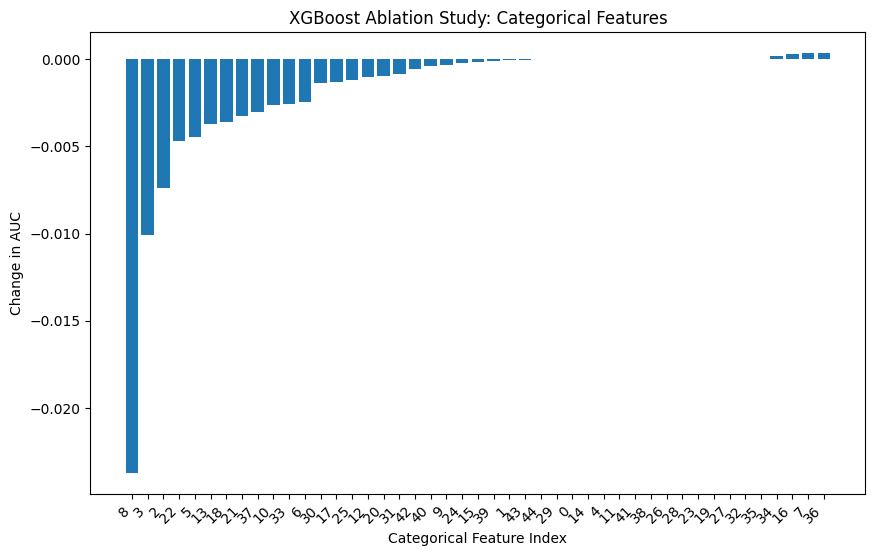

Continuous Features Selected from Ablation Study: ['365_NO2', 'birth_weight', 'Tri2_RH', '365_CO', 'mother_age']
[28  2 56 23  5]


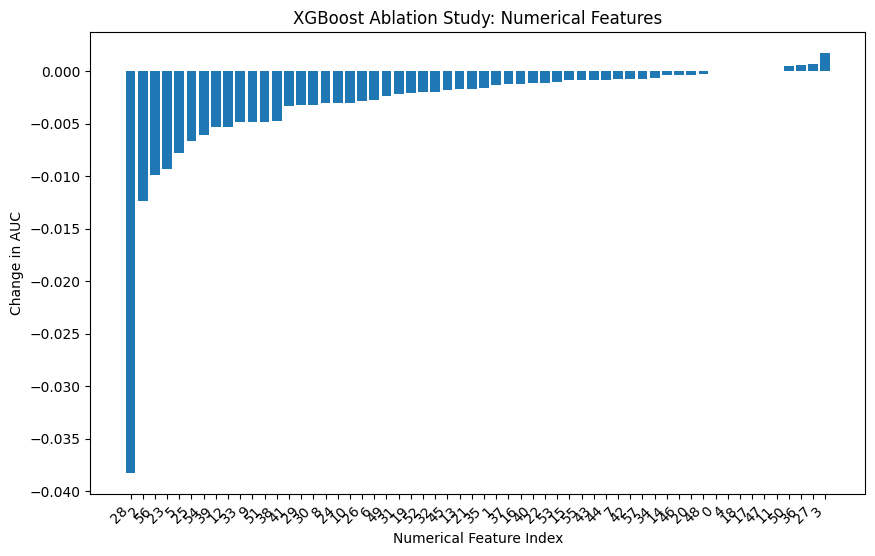

In [ ]:
# XGBoost Ablation Study
def xgb_ablation(X_train, y_train, X_val, y_val, feature_type, feature_index, replace_value):
    # Create a copy of the data to modify for the ablation study
    X_val_ablated = X_val.copy()
    X_val_ablated[:, feature_index] = replace_value

    # Create DMatrix
    dval_ablated = xgb.DMatrix(X_val_ablated, label=y_val)

    # Predict with the ablated data
    y_pred_prob_ablated = xgb_model.predict(dval_ablated)
    auc_ablated = roc_auc_score(y_val, y_pred_prob_ablated)

    return auc_ablated

# AUC Scores for Ablation Study
categorical_auc_scores = []
numerical_auc_scores = []

# Iterate through categorical features
for i in range(X_train.shape[1]):  # Assuming first columns are categorical
    if i < len(num_cat):  # categorical features
        auc_ablated = xgb_ablation(X_train, y_train, X_val, y_val, "categorical", i, 0)
        categorical_auc_scores.append(auc_ablated)
    else: # numerical features
        auc_ablated = xgb_ablation(X_train, y_train, X_val, y_val, "numerical", i, -100)
        numerical_auc_scores.append(auc_ablated)


# Calculate the AUC of the original model
y_pred_prob = xgb_model.predict(dval)
original_auc = roc_auc_score(y_val, y_pred_prob)

# Plot the changes in AUC for categorical features
delta_cat = np.array(categorical_auc_scores) - original_auc

# Sort the delta_cat array and get the indices
idx_cat = np.argsort(delta_cat)
print(f"Categorical Features Selected from Ablation Study: {[categorical_features[i] for i in idx_cat[:5]]}")
print(idx_cat[:5])

# Sort delta_cat based on sorted_indices
sorted_delta_cat = delta_cat[idx_cat]

# Create x-axis values (feature indices) in the original order
x_values = np.arange(len(delta_cat))


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_delta_cat)), sorted_delta_cat)
plt.xlabel('Categorical Feature Index')
plt.ylabel('Change in AUC')
plt.title('XGBoost Ablation Study: Categorical Features')

# Set x-axis ticks to original feature indices
plt.xticks(range(len(sorted_delta_cat)), x_values[idx_cat], rotation=45, ha='right')
plt.show()


# Plot the changes in AUC for numerical features
delta_numerical = np.array(numerical_auc_scores) - original_auc

# Sort the delta_numerical array and get the indices
idx_num = np.argsort(delta_numerical)
print(f"Continuous Features Selected from Ablation Study: {[continuous_features[i] for i in idx_num[:5]]}")
print(idx_num[:5])

# Sort delta_numerical based on sorted_indices
sorted_delta_numerical = delta_numerical[idx_num]

# Create x-axis values (feature indices) in the original order
x_values = np.arange(len(delta_numerical))


plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_delta_numerical)), sorted_delta_numerical)
plt.xlabel('Numerical Feature Index')
plt.ylabel('Change in AUC')
plt.title('XGBoost Ablation Study: Numerical Features')

# Set x-axis ticks to original feature indices
plt.xticks(range(len(sorted_delta_numerical)), x_values[idx_num], rotation=45, ha='right')

plt.show()

### Saliency Map

[ 8  3 21  5 22]
Categorical Feature Selected from Saliency Map: ['family support_good', 'firstborn', 'mold', 'edu_M_high', 'water_wall']
[41 20  9 15 48]
Continuous Features Selected from Saliency Map: ['Tri2_O3', 'Tri1_CO', 'BW_before_D', 'APGAR_5', 'Tri3_NO']


<BarContainer object of 58 artists>

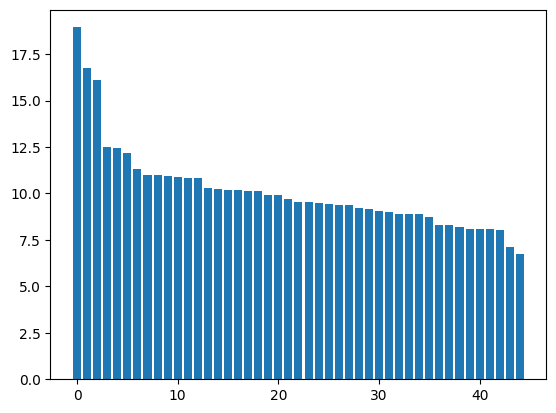

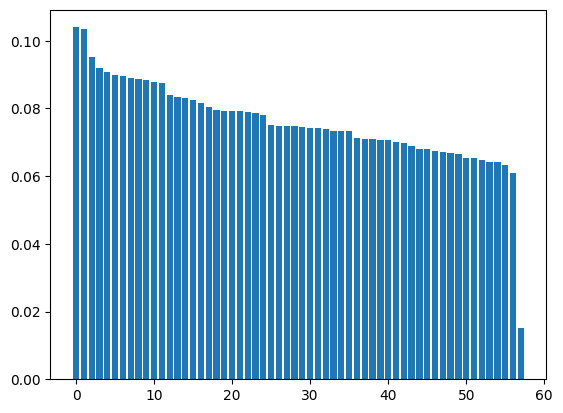

In [ ]:
# Calculate the gradient of the loss with respect to each feature
# For categorical features, calulate the gradient of the loss with respect to the embedding, and average over embed dimensions
model.eval()
grads_num = []

for x_cat, x_num, y in valid_loader:
    x_cat, x_num, y = x_cat.to(config.device), x_num.to(config.device), y.to(config.device)
    x_num.requires_grad = True
    y_pred = model(x_cat, x_num)
    loss = loss_function(y_pred, y)
    loss.backward()
    grads_num.append(x_num.grad.abs())
grads_cat = np.array([model.emb[i].weight.grad.abs().mean().cpu() for i in range(len(num_cat))])
grads_num = torch.cat(grads_num, dim=0).mean(dim=0).cpu().numpy()

i_cat = np.argsort(grads_cat)[::-1]
i_num = np.argsort(grads_num)[::-1]

print(i_cat[:5])
print(f"Categorical Feature Selected from Saliency Map: {[categorical_features[i] for i in i_cat[:5]]}")
print(i_num[:5])
print(f"Continuous Features Selected from Saliency Map: {[continuous_features[i] for i in i_num[:5]]}")



# plot the gradients for the categorical features
plt.figure()
plt.bar(range(len(num_cat)), grads_cat[i_cat])
plt.figure()
plt.bar(range(103-len(num_cat)), grads_num[i_num])